In [1]:
# For user-defined post processing and plotting functions
include(joinpath(@__DIR__, "..", "..", "..", "utils", "plot_utils.jl"))

plot_posterior_states_stacked (generic function with 1 method)

Welcome to the "how to" of Markov Chain Monte Carlo using Turing. A Julia software package allowing you to fit complex models with ease. 

## Case Study 1: Exponential Growth

We are going to establish an exponential model in this case study. The ODE and it's solution will be defined in the near future.  

First things first. Data! We will read our data from a CSV into a DataFrame. It's also smart to handle any necessary data conversions during this step. You may not need to and that's just fine! It all depends on what you are looking for.

Note: The "+ 1e-9" is merely a fail-safe against divide-by-zero errors when doing a log transform. Adding a value infitesimally near 0 makes no impact on the data itself and prevents the aformentioned error. Good quick trick to know!

In [2]:
## Cell 1 ##

using CSV, DataFrames

df = CSV.read("../../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells
log_y_obs = log.(y_obs .+ 1e-9)

14-element Vector{Float64}:
 14.304090572782945
 14.352003928478844
 14.375126345899698
 14.386490104550012
 14.488455031206701
 14.207552645740298
 14.580978400103845
 14.457364444136669
 14.508657738524219
 14.797589030376432
 14.880221294956703
 14.71159858252091
 14.73180128983843
 15.112973705377549

First we will setup the exponential ODE that will adapt to the data. To do this, you will use variables that Turing gives you by 'default'. Let me explain. Notice the 4 parameters being passed in. **du**, **u**, **p**, and **t**. **du** is to hold your ODE  system. **u** are you starting states. **p** are your parameters. **t** are your times. Turing and Julia will handle the passing of these under the hood. Just make sure you declare them correctly and in proper order. If you have states 1 and 2 then EVERYWHERE you make sure those states are passed in that exact order. Same with your parameters. Lots of things happen under the hood here for you and things are not always 'explicitly' passed, so make sure when you do pass things your order is always preserved.

**mum**: Growth Rate  
**y**: Initial Value

$$
\frac{dy}{dt} = \mu y
$$

In [3]:
## Cell 2 ##

function ode(du, u, p, t)
    mum = p[1]
    y = u[1]
    du[1] = mum * y
    return nothing
end

ode (generic function with 1 method)

This is where we create the MCMC 'loop': Sample Priors -> Estimate ODE @ times -> check fit

We declare the function to be probabilistic model named **fit_ode** using the **@model** tag. The inputs are as follows.

**log_y_obs**: Our log transformed observed data.  
**times**: The times at which the ODE is evaluated.  
**prob**: The prebuilt ODE.  

Next, priors. You have all kinds of options. Uniform, normal, lognormal, halfnormal. It all depends on what you need. For $\mu$ we chose a truncatednormal prior. This says, "we believe there is a normal distribution about some **x**, however, it cannot be below some **y** or above some **z**". For **N0**, we chose a lognormal distribution. This says, "we believe our value is around some **x** given a normalesque strictly positive distribution". For **sigma**, we chose a halfnormal distribution. This is usually used for your error or standard deviation since neither can be negative and you can tune how quickly it tails off. Below are the priors visualized. 

<img src="../../figures/priors_c1p1.png" width="300"/>

Next is solving the ODE. This will be a 2 step process. 

**1**: remake your problem with newly sampled elements.  
The inputs are as follows:  
**prob**: Premade ODE system.  
**u0**: State priors.  
**p**: Parameter priors.  
**tspan**: first and last of your observed times.   


**2**: solve the system at specific time points.  
the inputs are as follows:  
**pr**: remade system  
**Tsit5()**: Default.  
**saveat**: observed times.  
**abstol / restol**: Absolute tolerance / Relative tolerance. Default value chosen.  

**note**: See how when you're passing in values to this julia function there are both **,** and **;**? In julia this is to mark the difference between positional arguments (before **;**) and keyword arguments (after **;**).

The final part of the model is getting the likelihood (or fit if you prefer) of the model to the observed data. It's a bit layered here so we'll break it down part by part.

**log.(Array(sol)[1, :] .+ 1e-9)**: **sol** is the solver output. We force it into an array and grab the first row using the **[1, :]** indexing. Remember to be intentional with your indexing. Finally, we log scale the prediction.   
**log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))**: This is the actual likelihood calculation. Ensure the variable preceding the **~** here is the same as the one passed into **fit_ode**.


In [4]:
## Cell 3 ##

using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)    
    
    pr = remake(prob;
                p = [mum],
                u0 = [N0],
                tspan = (times[1], times[end]))

    sol = solve(pr, Tsit5();
                abstol = 1e-6, reltol = 1e-6,
                saveat = times)

    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

fit_ode (generic function with 2 methods)

This block is where we declare the ODE with initial values, call the model, and run the sampling.

To start,

**u0**: Initial state value(s). Make the inital value(s) from the observed data.  
**p**: Initial parameter value(s). Make these a value in the specified range of the prior you declared. Here we chose the center.  
**tspan**:  first and last values from your observed times.  
**prob**: The prebuild ODE.

Next is the call to run the sampling.

**model**: The model created above.  
**NUTS(1000, .95)**: This is telling you to use the NUTS sampler. 1000 is the amount of 'warm up' iterations it will do under the hood. .95 is the acceptance rate of the 'improved' solutions.   
**MCMCSerial()**: Tells the solver to run the chains sequentially.  
**1000**: number of posterior samples to be generated.  
**3**: number of chains.  
**progress**: either hides or shows the progress bar. Up to you.  

In [5]:
## Cell 4 ##

using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

model = fit_ode(log_y_obs, times, prob)
chain = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.006272220611572267
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×17×3 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 10.09 seconds
Compute duration  = 8.17 seconds
parameters        = mum, N0, sigma
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


To interpret the output we have some user-defined postprocessing and plotting functions. They are in our GitHub repo.

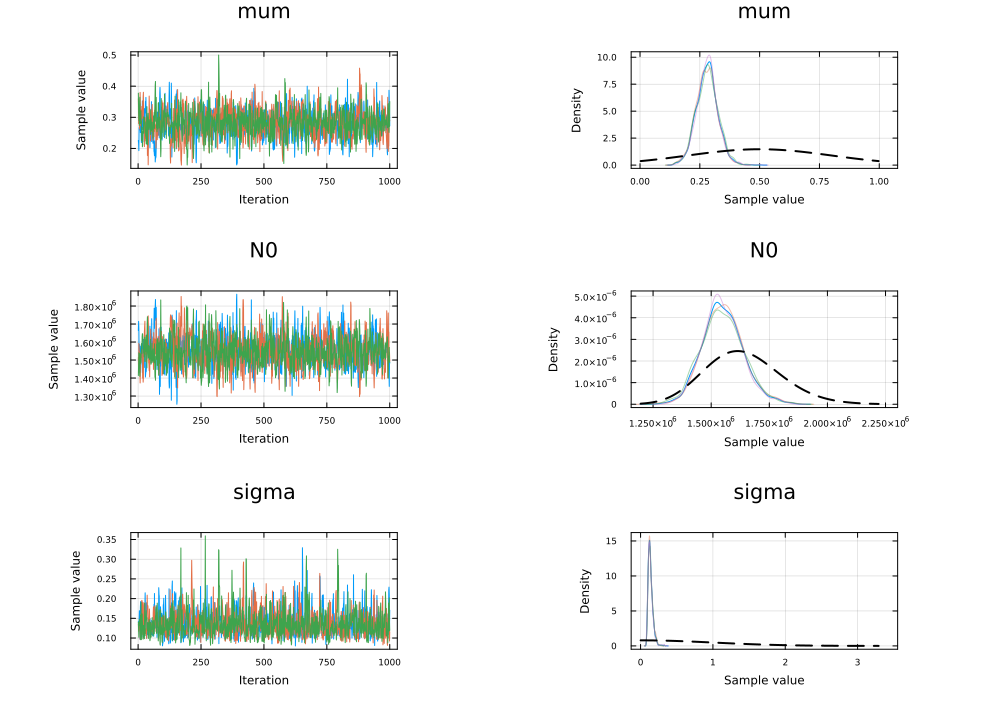

In [6]:
priors = Dict{Symbol,Distribution}(
    :mum   => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :N0    => LogNormal(log(1_630_000.0), 0.1),
    :sigma => truncated(Normal(0, 1.0), 0.0, Inf)
)

order = [:mum, :N0, :sigma]
plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

Now we interpret the results. Remember the ODE's from before.

$$
\frac{dy}{dt} = \mu y
$$

Take note of x-axis values at the peaks of the PDFs and the variables they represent. The x-axis values at those peaks are what the model found to be the optimal value for the equation. The right hand column is a frequency plot. This is just to make sure the model is exploring the parameter space well enough. 



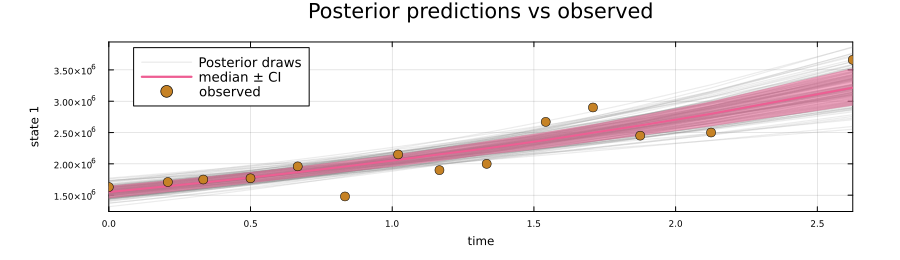

In [7]:
init_syms = [:N0]
param_syms = [:mum]
t_obs = times
y_obs = y_obs

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1],     # choose states to plot
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    ribbon_q=(0.1, 0.9),    # CI limits
    legend=:topleft,
    logy=false
)
display(plt)

This plot is showing how well the range of estimated chains fit the observed data. 

**CONGRATULATIONS!** you just ran you first MCMC!

## Case Study 1: Exponential Growth and Death

Now on to a more complex model. We will be using the same data as before.


In [14]:
## Cell 5 ##

using CSV, DataFrames

df = CSV.read("../../../case_study_1/python/data/phaeocystis_control.csv", DataFrame)

times    = df.times
y_obs    = df.cells
log_y_obs = log.(y_obs .+ 1e-9)

14-element Vector{Float64}:
 14.304090572782945
 14.352003928478844
 14.375126345899698
 14.386490104550012
 14.488455031206701
 14.207552645740298
 14.580978400103845
 14.457364444136669
 14.508657738524219
 14.797589030376432
 14.880221294956703
 14.71159858252091
 14.73180128983843
 15.112973705377549

$$
\frac{dy}{dt} = (\mu - \delta)\, y
$$

Here we are simply subtracting a **delta** from **mu** so that **delta** can simulate death. In short, we don't always need death (or something else comperable) data. We can simply make our ODE expressive about the data!

In [18]:
## Cell 6 ##

function ode(du, u, p, t)
    mum, delta = p
    y = u[1]
    du[1] = (mum - delta) * y
    return nothing
end

ode (generic function with 1 method)

Here is the model. Everything here should make sense. If something is confusing see the explination above cell 4. Still note that we have two likelihoods at the bottom since we are estimating two states.

In [19]:
## Cell 7 ##

using Turing
@model function fit_ode(log_y_obs, times, prob)
    mum   ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    delta ~ truncated(Normal(0.5, 0.3), 0.0, 1.0)
    N0    ~ LogNormal(log(1_630_000), 0.1)
    sigma ~ truncated(Normal(0, 1), 0, Inf)   
    
    pr = remake(prob;
                p = [mum, delta],
                u0 = [N0],
                tspan = (times[1], times[end]))
    
    # solve exactly at data times
    sol = solve(pr, Tsit5();  
                abstol = 1e-6, reltol = 1e-6,
                saveat = times)

    # likelihood at observation times
    log_y_pred = log.(Array(sol)[1, :] .+ 1e-9)
    log_y_obs ~ arraydist(Normal.(log_y_pred, sigma))
end

fit_ode (generic function with 2 methods)

Everything here is the same as before! See explination above cell 5 if you forgot something.

In [20]:
## Cell 8 ##

using DifferentialEquations

u0 = [y_obs[1]]
p = [0.5, 0.5]
tspan = (times[1], times[end])
prob = ODEProblem(ode, u0, tspan, p)

model    = fit_ode(log_y_obs, times, prob)
chain    = sample(model, NUTS(1000, .95), MCMCSerial(), 1000, 4; progress=false)

┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference C:\Users\Whisk\.julia\packages\Turing\Avpxw\src\mcmc\hmc.jl:215


Chains MCMC chain (1000×18×4 Array{Float64, 3}):

Iterations        = 1001:1:2000
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 11.96 seconds
Compute duration  = 11.61 seconds
parameters        = mum, delta, N0, sigma
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


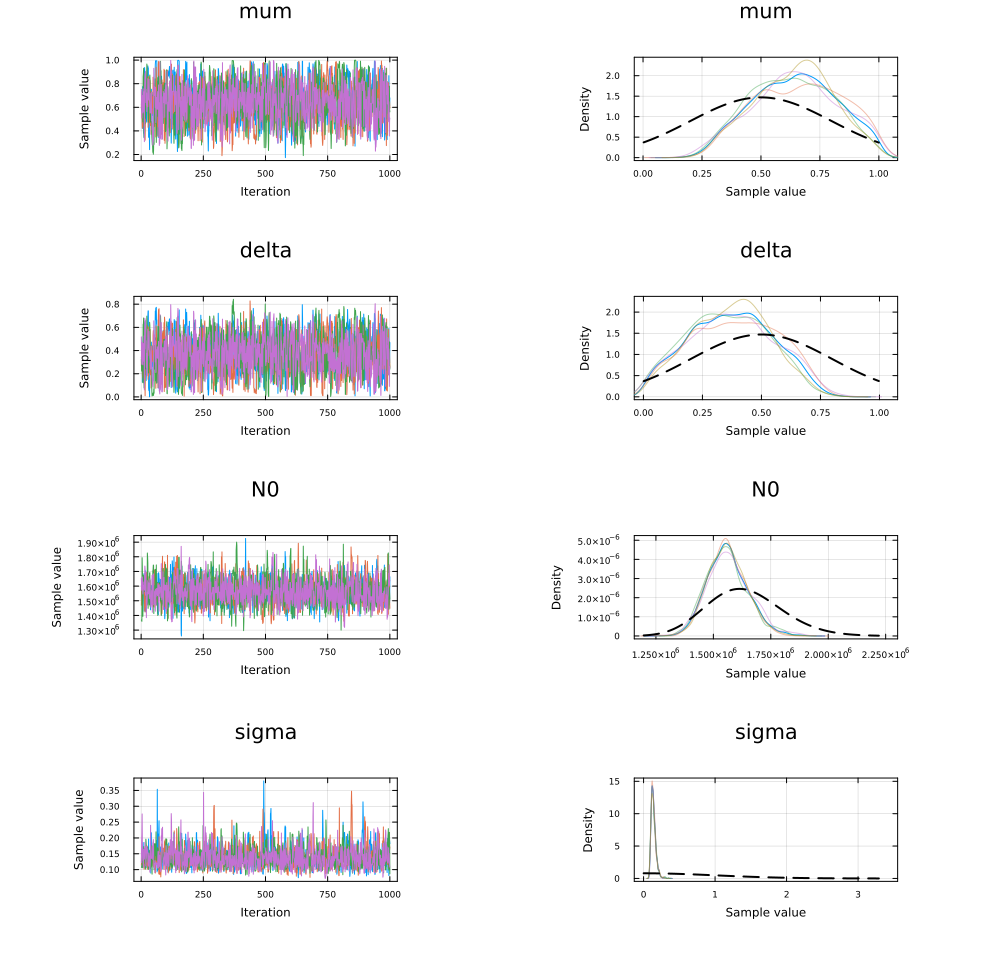

In [21]:
priors = Dict{Symbol,Distribution}(
    :mum   => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :delta => truncated(Normal(0.5, 0.3), 0.0, 1.0),
    :N0    => LogNormal(log(1_630_000.0), 0.1),
    :sigma => truncated(Normal(0, 1.0), 0.0, Inf)
)

order = [:mum, :delta, :N0, :sigma]
plot_trace_with_priors(chain; priors=priors, var_order=order, per_chain_density=true)  # also per-chain densities

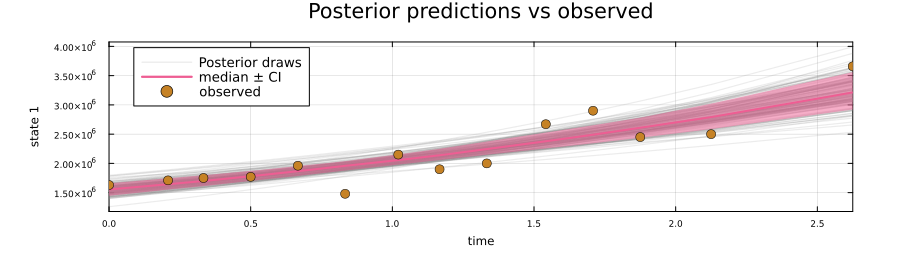

In [22]:
init_syms = [:N0]
param_syms = [:mum, :delta]
y_obs = y_obs
t_obs = times

plt = overlay_posterior_on_observed(
    chain, ode, t_obs, y_obs;
    init_syms=init_syms,
    param_syms=param_syms,
    which_states=[1],     # choose states to plot
    n_draws=150,            # how many posterior paths to overlay
    plot_ribbon=true,       # median ± CI band
    ribbon_q=(0.1, 0.9),    # CI limits
    legend=:topleft,
    logy=false
)
display(plt)